# Audio to Sheet Music Transcription
This project aims to address the issue of musical transcription by creating a machine learning model to convert audio files into notated sheet music. 

# Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from data.dataset import MaestroDataset
from torch.utils.data import DataLoader
import librosa.display

# Data
This project uses the MAESTRO (MIDI and Audio Edited for Synchronous TRacks and Organization) dataset. This dataset contains about 200 hours of piano performance recordings paired with labeled, corresponding MIDI data. The data was collected in partnership with the International Piano-e-Competition, which competitors would perform on Yamaha Disklaviers with an integrated MIDI capture system.

## Load Dataset
Import the Dataset from the MaestroDataset class

In [ ]:
# Initialize dataset
dataset = MaestroDataset(
    root_dir="maestro-v3.0.0",
    year="2017",
    subset_size=5  # for quick loading
)

# Preview number of samples
print(f"Total samples: {len(dataset)}")

Total samples: 5


## Inspect a sample

In [3]:
mel, roll = dataset[0]
print("Mel shape:", mel.shape)   # (1, n_mels, T)
print("Roll shape:", roll.shape) # (88, T)

Mel shape: torch.Size([1, 229, 14558])
Roll shape: torch.Size([88, 14558])


## Visualization
Visualizing both the audio spectrogram and corresponding note activations side-by-side

### Stacked

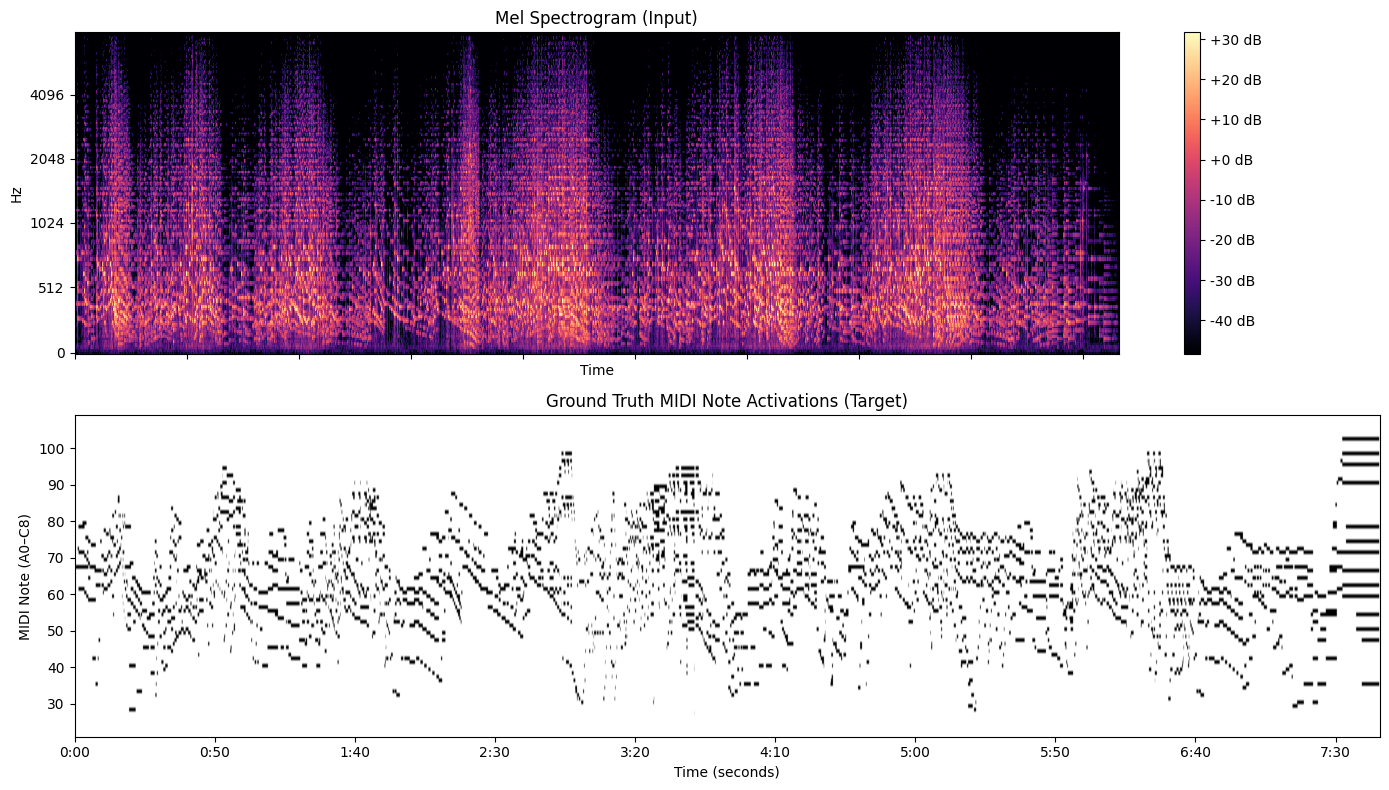

In [4]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- 1. Mel Spectrogram ---
mel_db = mel.squeeze(0).numpy()

img = librosa.display.specshow(
    mel_db,
    sr=dataset.sr,
    hop_length=dataset.hop_length,
    x_axis="time",
    y_axis="mel",
    fmax=8000,
    cmap="magma",
    ax=ax[0]
)
fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
ax[0].set_title("Mel Spectrogram (Input)")

# --- 2. MIDI Ground Truth ---
roll_np = roll.numpy()

ax[1].imshow(
    roll_np,
    aspect="auto",
    origin="lower",
    cmap="gray_r",
    extent=[0, roll_np.shape[1] * dataset.hop_length / dataset.sr, 21, 109],
)
ax[1].set_title("Ground Truth MIDI Note Activations (Target)")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("MIDI Note (A0–C8)")

plt.tight_layout()
plt.show()

### Overlay

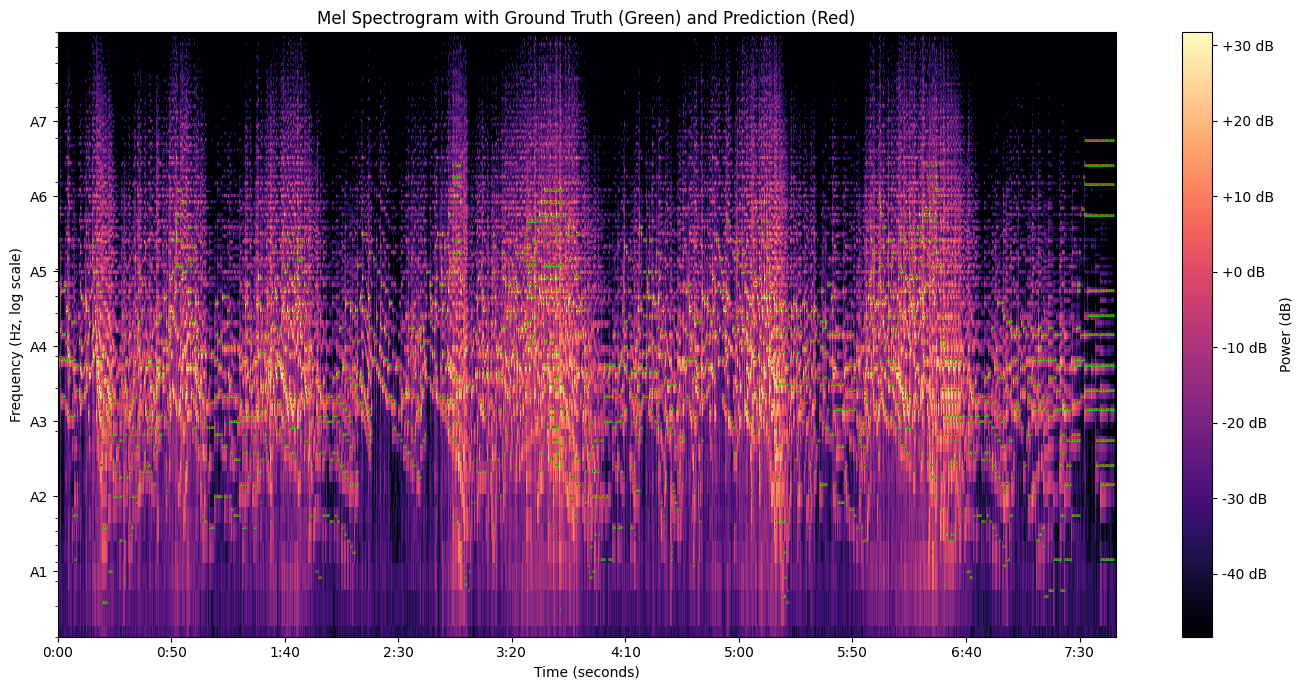

In [5]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def plot_transcription_overlay(
    mel_db,
    roll_true,
    sr,
    hop_length,
    roll_pred=None,
    fmax=8000,
    title="Mel Spectrogram with MIDI Overlays"
):
    """
    Visualize mel spectrogram with optional ground-truth and predicted MIDI note overlays.

    Args:
        mel_db: np.ndarray of shape (n_mels, T)
        roll_true: np.ndarray of shape (88, T), ground-truth MIDI activations
        sr: sample rate
        hop_length: hop length used in STFT
        roll_pred: (optional) np.ndarray of shape (88, T), predicted activations
        fmax: upper limit of mel frequency display
    """
    times = np.arange(mel_db.shape[1]) * hop_length / sr

    plt.figure(figsize=(14, 7))

    # --- 1️⃣ Mel Spectrogram ---
    img = librosa.display.specshow(
        mel_db,
        sr=sr,
        hop_length=hop_length,
        x_axis="time",
        y_axis="mel",
        fmax=fmax,
        cmap="magma",
    )
    plt.colorbar(img, format="%+2.0f dB", label="Power (dB)")

    # --- 2️⃣ Overlay Ground Truth Notes ---
    for pitch in range(roll_true.shape[0]):
        active = roll_true[pitch] > 0
        if np.any(active):
            onset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == 1)[0]
            offset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == -1)[0]
            freq_hz = 440.0 * (2.0 ** ((21 + pitch - 69) / 12.0))
            for on, off in zip(onset_idx, offset_idx):
                plt.hlines(
                    y=freq_hz,
                    xmin=on * hop_length / sr,
                    xmax=off * hop_length / sr,
                    color="lime",
                    linewidth=2.0,
                    alpha=0.8,
                )

    # --- 3️⃣ Overlay Predicted Notes (optional) ---
    if roll_pred is not None:
        for pitch in range(roll_pred.shape[0]):
            active = roll_pred[pitch] > 0
            if np.any(active):
                onset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == 1)[0]
                offset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == -1)[0]
                freq_hz = 440.0 * (2.0 ** ((21 + pitch - 69) / 12.0))
                for on, off in zip(onset_idx, offset_idx):
                    plt.hlines(
                        y=freq_hz,
                        xmin=on * hop_length / sr,
                        xmax=off * hop_length / sr,
                        color="red",
                        linewidth=1.5,
                        alpha=0.7,
                    )

    # --- 4️⃣ Log-Frequency Scaling & Formatting ---
    plt.yscale("log")
    plt.ylim(30, fmax)
    plt.yticks(
        [55, 110, 220, 440, 880, 1760, 3520],
        ["A1", "A2", "A3", "A4", "A5", "A6", "A7"],
    )

    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz, log scale)")
    plt.tight_layout()
    plt.show()

mel_db = mel.squeeze(0).numpy()
roll_true = roll.numpy()

# Example: fake predictions (for demo)
roll_pred = roll_true.copy()
roll_pred[:, ::3] = 0  # pretend the model missed every third frame

plot_transcription_overlay(
    mel_db,
    roll_true,
    sr=dataset.sr,
    hop_length=dataset.hop_length,
    roll_pred=roll_pred,
    title="Mel Spectrogram with Ground Truth (Green) and Prediction (Red)"
)

# CNN -> RNN Model
Processing audio data requires capturing both spectral (frequency content) and temporal (time-varying) features. To achieve this, we  use a combination of a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN). Audio data can be represented as a 2D image by converting the audio into its time–frequency representation. The 2D image will contain time frames in the x axis, frequency bins in the y axis, and each time-frequency point representing energy intensity.

## Small Training Batch

### Check Training input size

In [ ]:
from data.dataset import MaestroDataset
from train.train_transcriber import collate_fn
from torch.utils.data import DataLoader

ds = MaestroDataset("maestro-v3.0.0", year="2017", subset_size=5)
dl = DataLoader(ds, batch_size=2, collate_fn=collate_fn)

mel_batch, roll_batch = next(iter(dl))
print("Mel batch:", mel_batch.shape)
print("Roll batch:", roll_batch.shape)


Mel batch: torch.Size([2, 1, 229, 20688])
Roll batch: torch.Size([2, 88, 20688])


### Run training

In [7]:
import torch
import torch.optim as optim
from models.transcription_model import TranscriptionModel
from train.train_transcriber import train_one_epoch, evaluate

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Reuse the DataLoader
train_loader = dl  # your DataLoader with collate_fn
val_loader = dl    # reuse same small loader for testing

# Initialize the model and optimizer
model = TranscriptionModel(model_type="cnn_rnn", device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Run a tiny training loop
for epoch in range(1, 5):  # 5 epochs just for a test
    print(f"\nEpoch {epoch}")
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = evaluate(model, val_loader, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Using device: cpu

Epoch 1


Train Loss: 0.6815 | Val Loss: 0.6633

Epoch 2


Train Loss: 0.6407 | Val Loss: 0.6237

Epoch 3


Train Loss: 0.5993 | Val Loss: 0.5766

Epoch 4


Train Loss: 0.5543 | Val Loss: 0.5237
